# Facebook & Insta ANOVA

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 200)

In [3]:
fpath = os.path.join('data')
df_sns_clean = pd.read_csv(os.path.join(fpath,'df_sns_cleaned.csv'),encoding = 'utf-8')


### 데이터 확인

In [35]:
df_sns_clean.head()

,BrandID,BrandCategory,PhotoID,PostURL,PhotoURL,PostDate,PostTime,DownloadDate,Type,type_video,Like,LikeAlbum,Comments,Comments_album,NumHashtags,Content,ContentWithoutLink,X1SNS,X2brand,X3model,X31number,X32face,X33body,X34modelposition,X4background,X5text,X51words,X52,X53textposition,X54promotingmessa,X6brandname,X61brandexpose,X62,X63brandposition,X64brandvisib,X65partofprod,X66whproduct,X7logo,X71logoexposure,X72,X73logoposition,X74logotype,X75logovisib,X76logopartofprod,X8product,X81productexpose,X82,X83productposition,X9,X10angle,X11,X12hashtag,X12_1number,X12_2_1content,X12_2_2,X12_2_3,X12_2_4,X12_2_5,X12_2_6,X13text,X13_1,X13_2promo,X13_2promo_wo_kor,X13_3link,XBrandCategory_SPA,XBrandCategory_casual,XBrandCategory_luxuries,XBrandCategory_sport,X34modelposition_1,X34modelposition_2,X34modelposition_3,X34modelposition_4,X34modelposition_5,X34modelposition_6,X34modelposition_7,X34modelposition_8,X34modelposition_9,X4background_indoor,X4background_others,X4background_outdoor,X4background_wall,X53textposition_1,X53textposition_2,X53textposition_3,X53textposition_4,X53textposition_5,X53textposition_6,X53textposition_7,X53textposition_8,X53textposition_9,X63brandposition_1,X63brandposition_2,X63brandposition_3,X63brandposition_4,X63brandposition_5,X63brandposition_6,X63brandposition_7,X63brandposition_8,X63brandposition_9,X66whproduct_accessories,X66whproduct_bag,X66whproduct_clothes_bottom,X66whproduct_clothes_top,X66whproduct_cosmetics,X66whproduct_hat,X66whproduct_others,X66whproduct_shoes,X73logoposition_1,X73logoposition_2,X73logoposition_3,X73logoposition_4,X73logoposition_5,X73logoposition_6,X73logoposition_7,X73logoposition_8,X73logoposition_9,X74logotype_both,X74logotype_image,X74logotype_text,X83productposition_1,X83productposition_2,X83productposition_3,X83productposition_4,X83productposition_5,X83productposition_6,X83productposition_7,X83productposition_8,X83productposition_9,X10angle_extreme_high,X10angle_eye,X10angle_high,X10angle_low,X10angle_other
0,1,SPA,1,https://www.facebook.com/hmtheus/videos/202686...,https://m.facebook.com/story.php?story_fbid=20...,2018-01-08,2:24,2018-05-26,VIDEO,1,187.0,NaN,134.0,NaN,3.0,Holographic highlighters and icy-cool shimmer ...,Holographic highlighters and icy-cool shimmer ...,1,1,1,1.0,1.0,2.0,"1,2,3,4,5,6,8,9",1.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,NaN,"6,8,9",NaN,3.0,NaN,1,3.0,2.0,2.0,1.0,0.0,0.0,0.0,1,25,2.0,0.0,1.0,1,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,1,0,0,0
1,1,SPA,2,https://www.facebook.com/hmtheus/photos/a.1514...,https://scontent-icn1-1.xx.fbcdn.net/v/t1.0-9/...,2018-01-07,7:32,2018-05-26,PICTURE,0,434.0,NaN,100.0,NaN,1.0,Somewhere between versatile neutral and a stat...,Somewhere between versatile neutral and a stat...,1,1,0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,1,1.0,NaN,"2,3",0.0,1.0,"1,2",1,1.0,NaN,"2,3",2.0,0.0,1.0,1,1.0,NaN,"1,2,3,4,5,6,7,8,9",NaN,3.0,NaN,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,19,1.0,1.0,1.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0
2,1,SPA,3,https://www.facebook.com/hmtheus/photos/ms.c.e...,https://scontent-icn1-1.xx.fbcdn.net/v/t1.0-9/...,2018-01-07,1:47,2018-05-26,PICTURE,0,1.0,148.0,0.0,44.0,2.0,"To get your skin through the cold season, you ...","To get your skin through the cold season, you ...",1,1,1,1.0,1.0,2.0,"1,2,3,4,5,6,7,8,9",1.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,NaN,"6,7,9",NaN,3.0,NaN,1,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1,19,2.0,0.0,1.0,1,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## ANOVA

### Normalization

In [99]:
df_sns_clean = df_sns_clean[df_sns_clean.loc[:,"Like"].isna() == False]

In [113]:
from sklearn.preprocessing import StandardScaler

#Facebook
std_scaler = StandardScaler()
output = df_sns_clean.loc[df_sns_clean['X1SNS'] == 1, "Like"].values.reshape(-1, 1)
df_sns_clean.loc[df_sns_clean['X1SNS'] == 1, "Like_std"] = std_scaler.fit_transform(output)

#Instagram
std_scaler = StandardScaler()
output = df_sns_clean.loc[df_sns_clean['X1SNS'] == 2, "Like"].values.reshape(-1, 1)
df_sns_clean.loc[df_sns_clean['X1SNS'] == 2, "Like_std"] = std_scaler.fit_transform(output)


C:\Users\taeny\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [70]:
from scipy import stats
import researchpy as rp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [140]:
class anova_sns:
    def __init__(self,df,dv1,dv2,iv):
        self.data = df
        self.dv1 = dv1
        self.dv2 = dv2
        self.iv = iv
        
        self.interaction_col = self.dv1 + ":" + self.dv2
        self.data[self.interaction_col] =[str(x1) + ":" + str(x2) for x1,x2 in zip(self.data[self.dv1],self.data[self.dv2])]
    
    def table(self):
        return self.data
    def fit(self):
        self.formula = "%s ~ C(%s) + C(%s) + C(%s):C(%s)"%(self.iv,self.dv1,self.dv2,self.dv1,self.dv2)
        self.lm = ols(self.formula,self.data).fit()
        
        return self.lm
    
    def result(self):
        return anova_lm(self.lm,typ=2)
        
    def posthoc(self,treatment,alpha_value = 0.05):
        if treatment == 'dv1':
             tukey = pairwise_tukeyhsd(self.data[self.iv], self.data[self.dv1], alpha=alpha_value)
        elif treatment == 'dv2':
            tukey = pairwise_tukeyhsd(self.data[self.iv], self.data[self.dv2], alpha=alpha_value)
            
        elif treatment == 'inter':
            tukey = pairwise_tukeyhsd(self.data[self.iv], self.data[self.interaction_col], alpha=alpha_value)
        
        else:
            tukey = 'erorr'
            
        return print(tukey)
    
        

## 3. Model

In [141]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X3model'

df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv] == 0, dv] = "No_Model"
df.loc[df[dv] == 1, dv] = "Model"

anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.001132,1.0,0.001131,0.973174
C(X3model),1.223959,1.0,1.222548,0.268995
C(X1SNS):C(X3model),0.480647,1.0,0.480093,0.488461
Residual,1990.295394,1988.0,NaN,NaN


### 3-1. Model Number

In [199]:
df_sns_clean['X31number']

0       1.0
1       NaN
2       1.0
3       NaN
4       NaN
       ... 
1992    1.0
1993    2.0
1994    2.0
1995    1.0
1996    1.0
Name: X31number, Length: 1992, dtype: float64

In [200]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X3model'
dv2 = 'X31number'

dv_cat = 'X31number_cat'

df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False) & (df_sns_clean[dv2].isna() == False),[iv,dv_sns,dv2]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv2]==1,dv_cat] = 'One'
df.loc[df[dv2]==2,dv_cat] = 'Two'
df.loc[df[dv2]==3,dv_cat] = 'Three'
df.loc[df[dv2]>3,dv_cat] = 'Group'


anova = anova_sns(df,dv_sns,dv_cat,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.216017,1.0,0.179733,0.671671
C(X31number_cat),31.368093,3.0,8.699735,0.000010
C(X1SNS):C(X31number_cat),1.867859,3.0,0.518038,0.669911
Residual,1610.518261,1340.0,NaN,NaN


In [201]:
anova.posthoc('dv2')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Group    One  -0.5073  0.001 -0.7797 -0.2348   True
 Group  Three  -0.5321 0.0195 -1.0031 -0.0611   True
 Group    Two  -0.6003  0.001 -0.9282 -0.2725   True
   One  Three  -0.0248    0.9 -0.4295  0.3798  False
   One    Two  -0.0931 0.6807 -0.3154  0.1292  False
 Three    Two  -0.0682    0.9 -0.5121  0.3756  False
----------------------------------------------------


In [202]:
df_table = anova.table()
df_graph = df_table.groupby([dv_cat]).mean().reset_index()

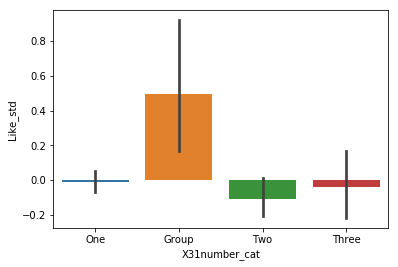

In [204]:
sns.catplot(x = dv_cat,y=iv,data = df_table, kind="bar")

### 3-2. Model Face


In [181]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X3model'
dv2 = 'X32face'

dv_cat = 'X32face_cat'

df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False) & (df_sns_clean[dv2].isna() == False),[iv,dv_sns,dv2]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv2]==1,dv_cat] = 'Y'
df.loc[df[dv2]==2,dv_cat] = 'N'
df.loc[df[dv2]==0,dv_cat] = 'X'



anova = anova_sns(df,dv_sns,dv_cat,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.155885,1.0,0.127576,0.721014
C(X32face_cat),1.522219,1.0,1.245787,0.264558
C(X1SNS):C(X32face_cat),0.006359,1.0,0.005204,0.942500
Residual,1642.225634,1344.0,NaN,NaN


### 3-1. Model Number

In [183]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X3model'
dv2 = 'X33body'

dv_cat = 'X33body_cat'

df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False) & (df_sns_clean[dv2].isna() == False),[iv,dv_sns,dv2]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv2]==1,dv_cat] = 'Y'
df.loc[df[dv2]==2,dv_cat] = 'N'
df.loc[df[dv2]==0,dv_cat] = 'X'



anova = anova_sns(df,dv_sns,dv_cat,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.112855,1.0,0.092329,0.761284
C(X33body_cat),0.006476,1.0,0.005298,0.941984
C(X1SNS):C(X33body_cat),1.640037,1.0,1.341751,0.246931
Residual,1641.563017,1343.0,NaN,NaN


### 4 Background

In [206]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X4background'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv]==1,dv] = 'Wall'
df.loc[df[dv]==2,dv] = 'Indoor'
df.loc[df[dv]==3,dv] = 'Outdoor'
df.loc[df[dv]==4,dv] = 'Other'


anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.479706,1.0,0.485382,0.486076
C(X4background),18.999318,3.0,6.408040,0.000256
C(X1SNS):C(X4background),12.201135,3.0,4.115167,0.006392
Residual,1960.799546,1984.0,NaN,NaN


In [207]:
anova.posthoc('dv2')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 Indoor   Other   0.1182 0.7171  -0.182  0.4184  False
 Indoor Outdoor    0.068 0.7554 -0.1171   0.253  False
 Indoor    Wall  -0.1338 0.1778 -0.3033  0.0358  False
  Other Outdoor  -0.0502    0.9 -0.3321  0.2316  False
  Other    Wall  -0.2519 0.0809 -0.5238    0.02  False
Outdoor    Wall  -0.2017  0.001 -0.3361 -0.0673   True
------------------------------------------------------


In [208]:
anova.posthoc('inter')

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
    FB:Indoor      FB:Other  -0.0648    0.9 -0.5279  0.3983  False
    FB:Indoor    FB:Outdoor   0.1875 0.4759 -0.0953  0.4703  False
    FB:Indoor       FB:Wall  -0.0713    0.9 -0.3409  0.1984  False
    FB:Indoor  Insta:Indoor   0.1788 0.7791 -0.1815   0.539  False
    FB:Indoor   Insta:Other   0.5375 0.0392  0.0142  1.0609   True
    FB:Indoor Insta:Outdoor   0.0725    0.9 -0.2295  0.3745  False
    FB:Indoor    Insta:Wall  -0.0555    0.9 -0.3143  0.2033  False
     FB:Other    FB:Outdoor   0.2523  0.631 -0.1842  0.6887  False
     FB:Other       FB:Wall  -0.0065    0.9 -0.4345  0.4215  False
     FB:Other  Insta:Indoor   0.2435  0.778 -0.2466  0.7337  False
     FB:Other   Insta:Other   0.6023 0.0642 -0.0177  1.2223  False
     FB:Other Insta:Outdoor   0.1373    0.9 -0.3118  0.5864  F

In [209]:
df_table = anova.table()
df_graph = df_table.groupby([dv]).mean().reset_index()

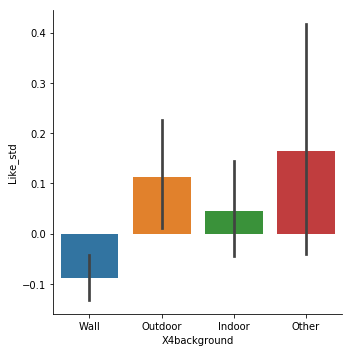

In [215]:
sns.catplot(x = dv,y=iv,data = df_table, kind="bar")

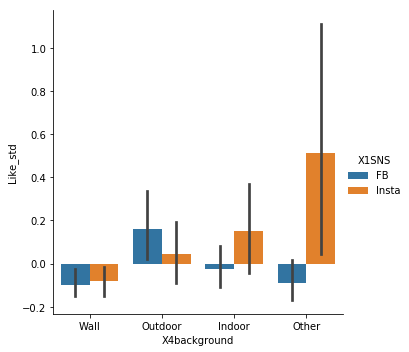

In [214]:
sns.catplot(x = dv,y=iv,hue=dv_sns,data = df_table, kind="bar")

## 5. Text

In [216]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X5text'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv]==1,dv] = 'Y'
df.loc[df[dv]==0,dv] = 'N'



anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.016778,1.0,0.016785,0.896930
C(X5text),4.033514,1.0,4.035249,0.044694
C(X1SNS):C(X5text),1.394900,1.0,1.395500,0.237620
Residual,1986.145932,1987.0,NaN,NaN


In [217]:
anova.posthoc('dv2')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     N      Y  -0.1306 0.0451 -0.2583 -0.0029   True
----------------------------------------------------


In [218]:
df_table = anova.table()

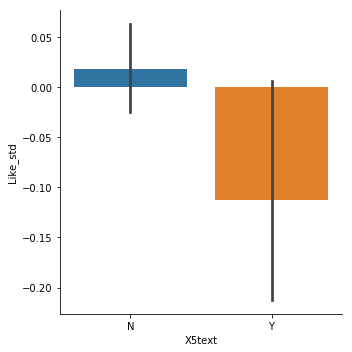

In [219]:
sns.catplot(x = dv,y=iv,data = df_table, kind="bar")

## Brand Name

In [220]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X6brandname'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv]==1,dv] = 'Y'
df.loc[df[dv]==0,dv] = 'N'

anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.000001,1.0,0.000001,0.999149
C(X6brandname),1.738230,1.0,1.736384,0.187750
C(X1SNS):C(X6brandname),0.148004,1.0,0.147846,0.700643
Residual,1990.113766,1988.0,NaN,NaN


## 7. Brand Logo

In [229]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X7logo'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
#df.loc[df[dv]==1,dv] = 'Y'
#df.loc[df[dv]==0,dv] = 'N'



anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.023570,1.0,0.023921,0.877102
C(X7logo),21.457151,1.0,21.776221,0.000003
C(X1SNS):C(X7logo),11.671483,1.0,11.845039,0.000590
Residual,1958.871367,1988.0,NaN,NaN


In [223]:
anova.posthoc('inter')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
   FB:N    FB:Y   0.0534 0.8245 -0.1138  0.2205  False
   FB:N Insta:N  -0.1296 0.1049 -0.2762   0.017  False
   FB:N Insta:Y   0.2377  0.001  0.0749  0.4006   True
   FB:Y Insta:N  -0.1829 0.0276 -0.3517 -0.0141   True
   FB:Y Insta:Y   0.1844 0.0476  0.0013  0.3674   True
Insta:N Insta:Y   0.3673  0.001  0.2028  0.5318   True
------------------------------------------------------


In [232]:
df_table = anova.table()
df_graph = df_table.groupby([dv]).mean().reset_index()

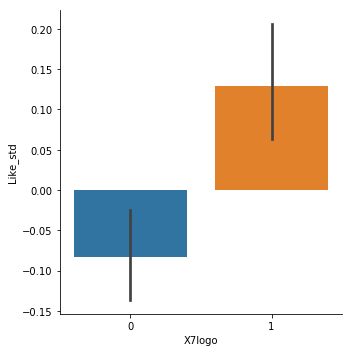

In [233]:
sns.catplot(x = dv,y=iv,data = df_table, kind="bar")

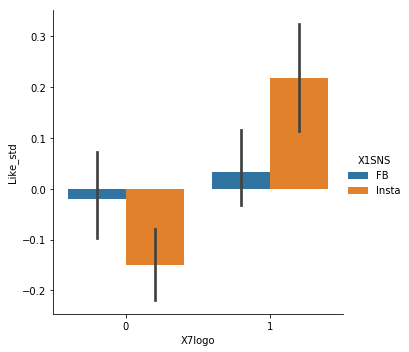

In [234]:
sns.catplot(x = dv,y=iv,hue=dv_sns,data = df_table, kind="bar")

## 7-1. Brand Logo Exposure

In [255]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X7logo'
dv2 = 'X71logoexposure'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & 
                      (df_sns_clean[dv_sns].isna() == False) & 
                      (df_sns_clean[dv].isna() == False)&
                      (df_sns_clean[dv2].isna() == False),[iv,dv_sns,dv2]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv2]==1,dv2] = 'Whole'
df.loc[df[dv2]==0,dv2] = 'Part'



anova = anova_sns(df,dv_sns,dv2,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),6.629860,1.0,6.885253,0.008862
C(X71logoexposure),0.000432,1.0,0.000449,0.983097
C(X1SNS):C(X71logoexposure),0.475812,1.0,0.494141,0.482297
Residual,745.290184,774.0,NaN,NaN


## 7-4. Brand logo type

In [236]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X74logotype'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & (df_sns_clean[dv_sns].isna() == False) & (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv]==1,dv] = 'Text'
df.loc[df[dv]==2,dv] = 'Image'
df.loc[df[dv]==3,dv] = 'Both'


anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),5.998763,1.0,6.456663,0.011248
C(X74logotype),22.905681,2.0,12.327063,0.000005
C(X1SNS):C(X74logotype),4.791280,2.0,2.578505,0.076540
Residual,718.179636,773.0,NaN,NaN


In [237]:
anova.posthoc('dv2')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Both  Image  -0.0639 0.8257 -0.3336 0.2058  False
  Both   Text   0.3291  0.001  0.1455 0.5127   True
 Image   Text    0.393  0.001  0.1429  0.643   True
---------------------------------------------------


In [238]:
anova.posthoc('inter')

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
    FB:Both    FB:Image   0.0103    0.9 -0.4324 0.4529  False
    FB:Both     FB:Text   0.1968 0.5304 -0.1349 0.5286  False
    FB:Both  Insta:Both   0.0525    0.9 -0.3089  0.414  False
    FB:Both Insta:Image  -0.1033    0.9 -0.6163 0.4097  False
    FB:Both  Insta:Text   0.5032  0.001  0.1774 0.8291   True
   FB:Image     FB:Text   0.1866 0.7363 -0.2119  0.585  False
   FB:Image  Insta:Both   0.0423    0.9 -0.3812 0.4657  False
   FB:Image Insta:Image  -0.1135    0.9  -0.672 0.4449  False
   FB:Image  Insta:Text    0.493 0.0049  0.0995 0.8865   True
    FB:Text  Insta:Both  -0.1443 0.7302   -0.45 0.1614  False
    FB:Text Insta:Image  -0.3001 0.4655 -0.7755 0.1753  False
    FB:Text  Insta:Text   0.3064 0.0116  0.0437 0.5691   True
 Insta:Both Insta:Image  -0.1558    0.9 -0.6524 0.3407  False
 Insta:B

In [239]:
df_table = anova.table()
df_graph = df_table.groupby([dv]).mean().reset_index()

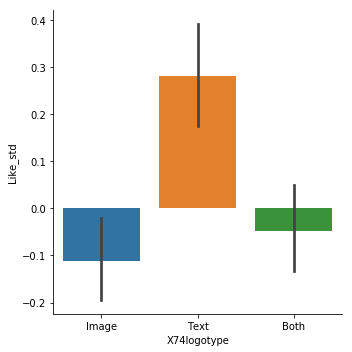

In [240]:
sns.catplot(x = dv,y=iv,data = df_table, kind="bar")

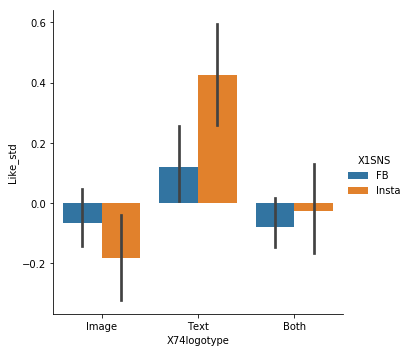

In [242]:
sns.catplot(x = dv,y=iv,hue=dv_sns,data = df_table, kind="bar")

## 7-5. Brand Logo visibility

In [258]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X7logo'
dv2 = "X75logovisib"


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & 
                      (df_sns_clean[dv_sns].isna() == False) & 
                      (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv,dv2]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv2].isna(),dv2] = 'X'
df.loc[df[dv2]==0,dv2] = 'L'
df.loc[df[dv2]==1,dv2] = 'H'


anova = anova_sns(df,dv_sns,dv2,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.057819,1.0,0.058678,0.808623
C(X75logovisib),23.417963,2.0,11.882970,0.000007
C(X1SNS):C(X75logovisib),11.660753,2.0,5.917012,0.002741
Residual,1956.921284,1986.0,NaN,NaN


In [259]:
anova.posthoc('dv2')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     H      L  -0.1002 0.3444 -0.2687  0.0683  False
     H      X  -0.2566  0.001 -0.3867 -0.1264   True
     L      X  -0.1564 0.0279 -0.2992 -0.0135   True
----------------------------------------------------


In [260]:
anova.posthoc('inter')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
   FB:H    FB:L  -0.0227    0.9 -0.3159  0.2706  False
   FB:H    FB:X  -0.0645    0.9 -0.2992  0.1702  False
   FB:H Insta:H   0.2282 0.1631 -0.0451  0.5014  False
   FB:H Insta:L   0.0879    0.9 -0.2164  0.3923  False
   FB:H Insta:X   -0.194 0.1769 -0.4302  0.0421  False
   FB:L    FB:X  -0.0418    0.9 -0.2799  0.1963  False
   FB:L Insta:H   0.2508 0.0999 -0.0253   0.527  False
   FB:L Insta:L   0.1106    0.9 -0.1964  0.4176  False
   FB:L Insta:X  -0.1714 0.3194 -0.4109  0.0682  False
   FB:X Insta:H   0.2926 0.0013  0.0797  0.5056   True
   FB:X Insta:L   0.1524 0.5113 -0.0992   0.404  False
   FB:X Insta:X  -0.1296 0.2059 -0.2922  0.0331  False
Insta:H Insta:L  -0.1402 0.7065 -0.4281  0.1477  False
Insta:H Insta:X  -0.4222  0.001 -0.6367 -0.2077   True
Insta:L Insta:X   -0.282 0.0187 -0.5349  -0.029   True
----------

In [261]:
df_table = anova.table()
df_graph = df_table.groupby([dv]).mean().reset_index()

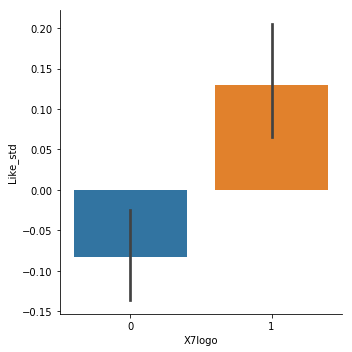

In [262]:
sns.catplot(x = dv,y=iv,data = df_table, kind="bar")

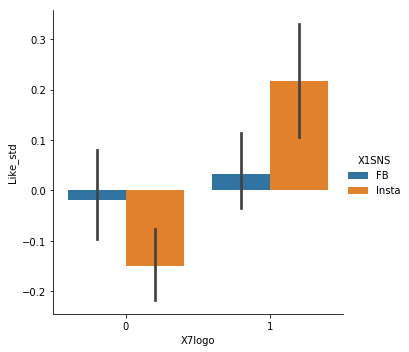

In [263]:
sns.catplot(x = dv,y=iv,hue=dv_sns,data = df_table, kind="bar")

## 8. Product Exposure

In [266]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X8product'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & 
                      (df_sns_clean[dv_sns].isna() == False) & 
                      (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv]==0,dv2] = 'N'
df.loc[df[dv]==1,dv2] = 'Y'


anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.000002,1.0,0.000002,0.998877
C(X8product),0.000181,1.0,0.000181,0.989272
C(X1SNS):C(X8product),4.811760,1.0,4.813726,0.028349
Residual,1987.188060,1988.0,NaN,NaN


In [267]:
anova.posthoc('inter')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   FB:0    FB:1  -0.1197 0.5249 -0.3468 0.1075  False
   FB:0 Insta:0  -0.2817 0.1635 -0.6316 0.0682  False
   FB:0 Insta:1  -0.0849 0.7425 -0.3108 0.1409  False
   FB:1 Insta:0   -0.162 0.4896 -0.4561 0.1321  False
   FB:1 Insta:1   0.0347 0.8768  -0.088 0.1575  False
Insta:0 Insta:1   0.1968 0.3105 -0.0964 0.4899  False
-----------------------------------------------------


## 8-1. Product Exposure degree

In [268]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X8product'
dv2 = "X81productexpose"


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & 
                      (df_sns_clean[dv_sns].isna() == False) & 
                      (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv,dv2]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv2].isna(),dv2] = 'X'
df.loc[df[dv2]==0,dv2] = 'Part'
df.loc[df[dv2]==1,dv2] = 'Whole'


anova = anova_sns(df,dv_sns,dv2,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.000213,1.0,0.000213,0.988352
C(X81productexpose),0.061951,2.0,0.030989,0.969487
C(X1SNS):C(X81productexpose),6.801946,2.0,3.402453,0.033486
Residual,1985.136102,1986.0,NaN,NaN


In [269]:
anova.posthoc('inter')

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
    FB:Part    FB:Whole  -0.0767    0.9 -0.3316 0.1781  False
    FB:Part        FB:X   0.0568    0.9 -0.2703  0.384  False
    FB:Part  Insta:Part  -0.0982    0.9 -0.4022 0.2059  False
    FB:Part Insta:Whole  -0.0076    0.9 -0.2619 0.2468  False
    FB:Part     Insta:X  -0.2248 0.5526 -0.6121 0.1624  False
   FB:Whole        FB:X   0.1336   0.65 -0.1226 0.3898  False
   FB:Whole  Insta:Part  -0.0214    0.9 -0.2474 0.2045  False
   FB:Whole Insta:Whole   0.0692  0.762 -0.0834 0.2218  False
   FB:Whole     Insta:X  -0.1481 0.7685 -0.4776 0.1814  False
       FB:X  Insta:Part   -0.155 0.6724 -0.4602 0.1502  False
       FB:X Insta:Whole  -0.0644    0.9 -0.3201 0.1913  False
       FB:X     Insta:X  -0.2817 0.3036 -0.6699 0.1065  False
 Insta:Part Insta:Whole   0.0906 0.8466 -0.1348  0.316  False
 Insta:P

## 10. Camera angle

In [270]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'X10angle'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & 
                      (df_sns_clean[dv_sns].isna() == False) & 
                      (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv,dv2]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"

#DV2
df.loc[df[dv]==1,dv] = 'High'
df.loc[df[dv]==2,dv] = 'High'
df.loc[df[dv]==3,dv] = 'Eye'
df.loc[df[dv]==4,dv] = 'Low'
df.loc[df[dv]==5,dv] = 'Other'
df.loc[df[dv]==6,dv] = 'Other'


anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.002243,1.0,0.002263,0.962064
C(X10angle),17.740606,3.0,5.965537,0.000479
C(X1SNS):C(X10angle),7.553947,3.0,2.540125,0.054855
Residual,1966.705447,1984.0,NaN,NaN


In [271]:
anova.posthoc('dv2')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   Eye   High   0.2177 0.0176  0.0272 0.4082   True
   Eye    Low   0.2161 0.0052  0.0484 0.3838   True
   Eye  Other   0.2085 0.6915 -0.2984 0.7154  False
  High    Low  -0.0016    0.9 -0.2373 0.2342  False
  High  Other  -0.0091    0.9 -0.5424 0.5241  False
   Low  Other  -0.0076    0.9 -0.5331  0.518  False
---------------------------------------------------


In [272]:
anova.posthoc('inter')

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1      group2   meandiff p-adj   lower  upper  reject
------------------------------------------------------------
    FB:Eye     FB:High   0.1524 0.7633 -0.1494 0.4542  False
    FB:Eye      FB:Low   0.0738    0.9 -0.2127 0.3602  False
    FB:Eye    FB:Other  -0.1743    0.9 -1.0534 0.7048  False
    FB:Eye   Insta:Eye  -0.0594    0.9 -0.2163 0.0975  False
    FB:Eye  Insta:High   0.2334 0.4185  -0.104 0.5707  False
    FB:Eye   Insta:Low   0.2871  0.032  0.0134 0.5607   True
    FB:Eye Insta:Other   0.4811 0.6086 -0.3339 1.2961  False
   FB:High      FB:Low  -0.0786    0.9 -0.4638 0.3065  False
   FB:High    FB:Other  -0.3267    0.9 -1.2427 0.5893  False
   FB:High   Insta:Eye  -0.2118 0.3972 -0.5132 0.0897  False
   FB:High  Insta:High    0.081    0.9 -0.3434 0.5053  False
   FB:High   Insta:Low   0.1347    0.9 -0.2411 0.5104  False
   FB:High Insta:Other   0.3287    0.9 -0.5259 1.1834  False
    FB:Low    FB:Other  

In [274]:
df_table = anova.table()

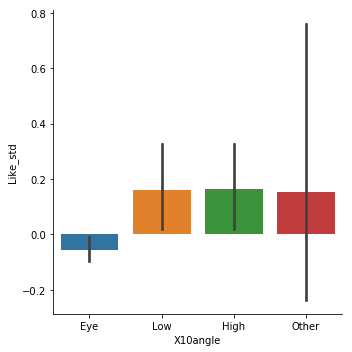

In [275]:
sns.catplot(x = dv,y=iv,data = df_table, kind="bar")

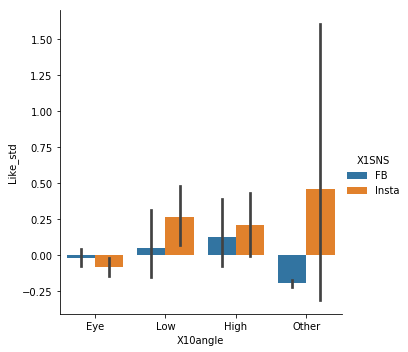

In [276]:
sns.catplot(x = dv,y=iv,hue=dv_sns,data = df_table, kind="bar")

## Logo X Cat

In [279]:
dv_sns = 'X1SNS'

iv = 'Like_std'
dv = 'BrandCategory'


df = df_sns_clean.loc[(df_sns_clean[iv].isna() == False) & 
                      (df_sns_clean[dv_sns].isna() == False) & 
                      (df_sns_clean[dv].isna() == False),[iv,dv_sns,dv]]

#SNS (DV1)
df.loc[df[dv_sns] == 1, dv_sns] = "FB"
df.loc[df[dv_sns] == 2, dv_sns] = "Insta"



anova = anova_sns(df,dv_sns,dv,iv)
anova.fit()
anova.result()

,sum_sq,df,F,PR(>F)
C(X1SNS),0.005530,1.0,0.007298,9.319318e-01
C(BrandCategory),333.232281,3.0,146.578214,8.577410e-86
C(X1SNS):C(BrandCategory),155.286336,3.0,68.305489,4.927545e-42
Residual,1503.481382,1984.0,NaN,NaN


In [280]:
anova.posthoc('dv2')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower  upper  reject
------------------------------------------------------
     SPA   casual   -0.177 0.0148 -0.329 -0.025   True
     SPA luxuries   0.3535  0.001 0.2177 0.4892   True
     SPA    sport   0.9905  0.001 0.8385 1.1425   True
  casual luxuries   0.5304  0.001 0.3784 0.6824   True
  casual    sport   1.1675  0.001 1.0007 1.3342   True
luxuries    sport    0.637  0.001  0.485  0.789   True
------------------------------------------------------


In [281]:
anova.posthoc('inter')

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
        FB:SPA      FB:casual    0.035    0.9 -0.2062  0.2763  False
        FB:SPA    FB:luxuries   0.5234  0.001  0.3074  0.7394   True
        FB:SPA       FB:sport   0.4356  0.001  0.1933   0.678   True
        FB:SPA      Insta:SPA  -0.0356    0.9 -0.2515  0.1802  False
        FB:SPA   Insta:casual  -0.4282  0.001 -0.6705 -0.1858   True
        FB:SPA Insta:luxuries   0.1485 0.4263 -0.0674  0.3643  False
        FB:SPA    Insta:sport   1.5016  0.001  1.2603  1.7428   True
     FB:casual    FB:luxuries   0.4884  0.001  0.2471  0.7296   True
     FB:casual       FB:sport   0.4006  0.001  0.1355  0.6657   True
     FB:casual      Insta:SPA  -0.0707    0.9 -0.3118  0.1705  False
     FB:casual   Insta:casual  -0.4632  0.001 -0.7283 -0.1981   True
     FB:casual Insta:luxuries   0.

In [282]:
df_table = anova.table()

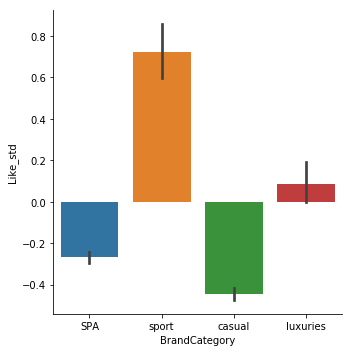

In [283]:
sns.catplot(x = dv,y=iv,data = df_table, kind="bar")

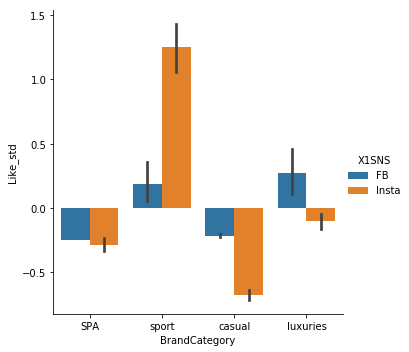

In [284]:
sns.catplot(x = dv,y=iv,hue=dv_sns,data = df_table, kind="bar")

## Chi Square

### 3Model

In [3]:
from scipy import stats
import researchpy as rp

In [15]:
def t_test_sns(df,dv):
    data = df.copy()
    
    facebook = data[data['X1SNS'] == 1]
    insta = data[data['X1SNS'] == 2]
    
    facebook_dv = facebook[dv]
    insta_dv = insta[dv]
    
    result = rp.ttest(facebook_dv,insta_dv,group1_name = 'Facebook',group2_name = 'Instagram')
    
    return result

In [16]:
def chi_sns(df,dv_idx,cat_dict = {1:'Y',0:'N'}):
    data = df.copy()
    
    sns_dict = {1:'Facebook',2:'instagram'}
    for k,v in sns_dict.items():
        
        data.loc[data['X1SNS']==k,['X1SNS']] = v
        
    
    yn_dict = cat_dict
    for k,v in yn_dict.items():
        
        data.loc[data[dv_idx]==k,[dv_idx]] = v
    
    iv = data['X1SNS']
    dv = data[dv_idx]
    
    #facebook['1SNS'] = 'facebook'
    #insta['1SNS'] = 'insta'
    
    
    result = rp.crosstab(iv, dv, test = 'chi-square', margins= True, correction = None, exact = False, expected_freqs= False)
    
    return result

In [17]:
def chi_iter_sns(df,dv_idx,cat_dict = None):
    data = df.copy()
    
    
    
    if cat_dict:
        
        test_dict = cat_dict
    
    
        for k,v in test_dict.items():
            data.loc[data[dv_idx]== k,dv_idx] = v

    
    sns_dict = {1:'Facebook',2:'instagram'}
    for k,v in sns_dict.items():
        
        data.loc[data['X1SNS']==k,['X1SNS']] = v
        
    iv = data['X1SNS']
    
        
    dv_dummies = pd.get_dummies(data[dv_idx])
    
    #facebook['1SNS'] = 'facebook'
    #insta['1SNS'] = 'insta'
    
    
    for dv_idx in dv_dummies:
        dv = dv_dummies[dv_idx]
        result = rp.crosstab(iv, dv, test = 'chi-square', margins= True, correction = None, exact = False, expected_freqs= False)
        
        
        
        p = result[1].iloc[1,1]
        score = importance(p)
        
        print('[%s]'%dv_idx)
        print(result[0],'\n')
        print(result[1],'\n')
        print('Importance: %s\n'%score)


 






In [18]:
def importance(p):
    score = 'X'
    if p <= 0.001:
        score = '***'
    elif p <= 0.01:
        score = '**'
    elif p <= 0.05:
        score = '*'
    
    return score
   # result[1].iloc[1,1]

In [19]:
col = 'X3model'

result = chi_sns(df_sns_clean,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)


df_model = df_sns_clean[df_sns_clean['X3model'] == 1]
chi_col = ['X32face', 'X33body']
for col in chi_col:
    print('[%s]'%col)
    result = chi_sns(df_model,col)
    p = result[1].iloc[1,1]
    print(result[0],'\n')
    print(result[1],'\n')
    score = importance(p)
    print('Importance: %s\n'%score)
    
    
#result[1].iloc[1,1]

[X3model]
          X3model            
                N     Y   All
X1SNS                        
Facebook      312   688  1000
instagram     337   660   997
All           649  1348  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    1.5401
1                    p-value =    0.2146
2               Cramer's phi =    0.0278 

Importance: X

[X32face]
          X32face            
                N     Y   All
X1SNS                        
Facebook      140   548   688
instagram     150   510   660
All           290  1058  1348 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    1.1286
1                    p-value =    0.2881
2               Cramer's phi =    0.0289 

Importance: X

[X33body]
          X33body           
              2.0    Y   All
X1SNS                       
Facebook      395  293   688
instagram     358  301   659
All           753  594  1347 

                Chi-square test  results
0  Pearson Chi-square ( 1.0

In [21]:
result = t_test_sns(df_model,'X31number')
p = result[1].iloc[3,1]
score = importance(p)

print('[X31number]')
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

[X31number]
    Variable       N      Mean        SD        SE  95% Conf.  Interval
0   Facebook   688.0  1.861919  2.848908  0.108614   1.648664  2.075173
1  Instagram   660.0  2.022727  3.016057  0.117400   1.792204  2.253250
2   combined  1348.0  1.940653  2.931949  0.079857   1.783996  2.097310 

                                Independent t-test    results
0             Difference (Facebook - Instagram) =     -0.1608
1                            Degrees of freedom =   1346.0000
2                                             t =     -1.0066
3                         Two side test p value =      0.3143
4  Mean of Facebook > mean of Instagram p value =      0.1571
5  Mean of Facebook < mean of Instagram p value =      0.8429
6                                     Cohen's d =     -0.0548
7                                     Hedge's g =     -0.0548
8                                 Glass's delta =     -0.0564
9                                             r =      0.0274 

Importance: X


In [22]:
position_col_name = 'X34modelposition_'
df_position = df_model

print("[[%s]]\n\n"%(position_col_name.replace("_","")))
position_col = [position_col_name in s for s  in df_position.columns]
position_columns = df_model.loc[:,position_col].columns

for col in position_columns:
    print('[%s]'%col)
    result = chi_sns(df_model,col)
    print(result[0],'\n')
    print(result[1],'\n')
    
    p = result[1].iloc[1,1]
    score = importance(p)
    print('Importance: %s\n'%score)

[[X34modelposition]]


[X34modelposition_1]
          X34modelposition_1           
                           N    Y   All
X1SNS                                  
Facebook                 306  382   688
instagram                288  372   660
All                      594  754  1348 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.0965
1                    p-value =    0.7560
2               Cramer's phi =    0.0085 

Importance: X

[X34modelposition_2]
          X34modelposition_2            
                           N     Y   All
X1SNS                                   
Facebook                  78   610   688
instagram                 59   601   660
All                      137  1211  1348 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    2.1212
1                    p-value =    0.1453
2               Cramer's phi =    0.0397 

Importance: X

[X34modelposition_3]
          X34modelposition_3           
                      

### 4background

In [23]:
chi_iter_sns(df_sns_clean,'X4background',{1:'wall',2:'indoor',3:'outdoor',4:'others'})

[indoor]
          indoor           
               0    1   All
X1SNS                      
Facebook     824  176  1000
instagram    880  117   997
All         1704  293  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =   13.7164
1                    p-value =    0.0002
2               Cramer's phi =    0.0829 

Importance: ***

[others]
          others          
               0   1   All
X1SNS                     
Facebook     944  56  1000
instagram    956  41   997
All         1900  97  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    2.3909
1                    p-value =    0.1220
2               Cramer's phi =    0.0346 

Importance: X

[outdoor]
          outdoor           
                0    1   All
X1SNS                       
Facebook      675  325  1000
instagram     765  232   997
All          1440  557  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =   21.1484
1               

### 5Text

In [24]:
col = 'X5text'

result = chi_sns(df_sns_clean,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

[X5text]
          X5text           
               N    Y   All
X1SNS                      
Facebook     839  161  1000
instagram    884  112   996
All         1723  273  1996 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    9.9622
1                    p-value =    0.0016
2               Cramer's phi =    0.0706 

Importance: **



In [25]:
df_text = df_sns_clean[df_sns_clean['X5text'] == 1]

In [26]:

#result = t_test_sns(df_test,'31number')


ttest_col = ['X51words']
for col in ttest_col:
    print('[%s]'%col)
    result = t_test_sns(df_text,col)
    p = result[1].iloc[3,1]
    print(result[0],'\n')
    print(result[1],'\n')
    score = importance(p)
    print('Importance: %s\n'%score)
    
    

[X51words]
    Variable      N      Mean         SD        SE  95% Conf.  Interval
0   Facebook  161.0  6.416149   8.595463  0.677417   5.078316  7.753982
1  Instagram  112.0  6.160714  13.061568  1.234202   3.715060  8.606368
2   combined  273.0  6.311355  10.634733  0.643643   5.044199  7.578511 

                                Independent t-test   results
0             Difference (Facebook - Instagram) =     0.2554
1                            Degrees of freedom =   271.0000
2                                             t =     0.1949
3                         Two side test p value =     0.8456
4  Mean of Facebook > mean of Instagram p value =     0.5772
5  Mean of Facebook < mean of Instagram p value =     0.4228
6                                     Cohen's d =     0.0240
7                                     Hedge's g =     0.0239
8                                 Glass's delta =     0.0297
9                                             r =     0.0118 

Importance: X



In [27]:
col = 'X54promotingmessa'

result = chi_sns(df_text,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

[X54promotingmessa]
          X54promotingmessa         
                          N   Y  All
X1SNS                               
Facebook                141  20  161
instagram               103   9  112
All                     244  29  273 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    1.3387
1                    p-value =    0.2473
2               Cramer's phi =    0.0700 

Importance: X



In [28]:
position_col_name = 'X53textposition_'
df_position = df_text

print("[[%s]]\n\n"%(position_col_name.replace("_","")))
position_col = [position_col_name in s for s  in df_position.columns]
position_columns = df_model.loc[:,position_col].columns

for col in position_columns:
    print('[%s]'%col)
    result = chi_sns(df_model,col)
    print(result[0],'\n')
    print(result[1],'\n')
    p = result[1].iloc[1,1]
    score = importance(p)
    print('Importance: %s\n'%score)

[[X53textposition]]


[X53textposition_1]
          X53textposition_1         
                          N   Y  All
X1SNS                               
Facebook                 76  17   93
instagram                40  11   51
All                     116  28  144 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.2275
1                    p-value =    0.6334
2               Cramer's phi =    0.0397 

Importance: X

[X53textposition_2]
          X53textposition_2         
                          N   Y  All
X1SNS                               
Facebook                 72  21   93
instagram                32  19   51
All                     104  40  144 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    3.5354
1                    p-value =    0.0601
2               Cramer's phi =    0.1567 

Importance: X

[X53textposition_3]
          X53textposition_3         
                          N   Y  All
X1SNS                             

### 6Brandname

In [29]:
col = 'X6brandname'

result = chi_sns(df_sns_clean,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

[X6brandname]
          X6brandname           
                    N    Y   All
X1SNS                           
Facebook          812  188  1000
instagram         811  186   997
All              1623  374  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.0068
1                    p-value =    0.9343
2               Cramer's phi =    0.0018 

Importance: X



In [33]:
df_brand = df_sns_clean[(df_sns_clean['X6brandname'] == 1)]

cols = ['X61brandexpose','X65partofprod']
for col in cols: 
    result = chi_sns(df_brand,col)
    p = result[1].iloc[1,1]
    score = importance(p)

    print('[%s]'%col)
    print(result[0],'\n')
    print(result[1],'\n')
    print('Importance: %s\n'%score)
    
col = 'X64brandvisib'
result = chi_sns(df_brand,col,{0:'low',1:'high'})
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')

print('Importance: %s\n'%score)

[X61brandexpose]
          X61brandexpose          
                       N    Y  All
X1SNS                             
Facebook              11  177  188
instagram             25  161  186
All                   36  338  374 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    6.1913
1                    p-value =    0.0128
2               Cramer's phi =    0.1287 

Importance: *

[X65partofprod]
          X65partofprod          
                      N    Y  All
X1SNS                            
Facebook             91   97  188
instagram            34  152  186
All                 125  249  374 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =   38.1310
1                    p-value =    0.0000
2               Cramer's phi =    0.3193 

Importance: ***

[X64brandvisib]
          X64brandvisib          
                   high  low  All
X1SNS                            
Facebook             94   94  188
instagram            95   91  186

In [34]:

position_col_name = 'X63brandposition_'
df_position = df_brand

print("[[%s]]\n\n"%(position_col_name.replace("_","")))
position_col = [position_col_name in s for s  in df_position.columns]
position_columns = df_model.loc[:,position_col].columns

for col in position_columns:
    print('[%s]'%col)
    result = chi_sns(df_model,col)
    p = result[1].iloc[1,1]
    print(result[0],'\n')
    print(result[1],'\n')
    score = importance(p)
    print('Importance: %s\n'%score)

[[X63brandposition]]


[X63brandposition_1]
          X63brandposition_1         
                           N   Y  All
X1SNS                                
Facebook                  70   8   78
instagram                 58  11   69
All                      128  19  147 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    1.0516
1                    p-value =    0.3051
2               Cramer's phi =    0.0846 

Importance: X

[X63brandposition_2]
          X63brandposition_2         
                           N   Y  All
X1SNS                                
Facebook                  67  11   78
instagram                 55  14   69
All                      122  25  147 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.9930
1                    p-value =    0.3190
2               Cramer's phi =    0.0822 

Importance: X

[X63brandposition_3]
          X63brandposition_3         
                           N   Y  All
X1SNS           

In [35]:

position_col_name = 'X66whproduct_'
df_position = df_brand

print("[[%s]]\n\n"%(position_col_name.replace("_","")))
position_col = [position_col_name in s for s  in df_position.columns]
position_columns = df_model.loc[:,position_col].columns

for col in position_columns:
    print('[%s]'%col)
    result = chi_sns(df_model,col)
    print(result[0],'\n')
    print(result[1],'\n')
    p = result[1].iloc[1,1]
    score = importance(p)
    print('Importance: %s\n'%score)

[[X66whproduct]]


[X66whproduct_accessories]
          X66whproduct_accessories       
                                 N  Y All
X1SNS                                    
Facebook                        43  1  44
instagram                       53  0  53
All                             96  1  97 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    1.2171
1                    p-value =    0.2699
2               Cramer's phi =    0.1120 

Importance: X

[X66whproduct_bag]
          X66whproduct_bag       
                         N  Y All
X1SNS                            
Facebook                39  5  44
instagram               51  2  53
All                     90  7  97 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    2.0685
1                    p-value =    0.1504
2               Cramer's phi =    0.1460 

Importance: X

[X66whproduct_clothes_bottom]
          X66whproduct_clothes_bottom       
                                    N 

### 7Brandlogo

In [36]:
col = 'X7logo'

result = chi_sns(df_sns_clean,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

[X7logo]
          X7logo           
               N    Y   All
X1SNS                      
Facebook     623  377  1000
instagram    591  406   997
All         1214  783  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    1.9131
1                    p-value =    0.1666
2               Cramer's phi =    0.0310 

Importance: X



In [39]:
df_logo = df_sns_clean[(df_sns_clean['X7logo'] == 1)]

##
col = 'X71logoexposure'
result = chi_sns(df_logo,col,{1:'whole',0:'part'})
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

##
col = 'X75logovisib'
result = chi_sns(df_logo,col,{0:'low',1:'high'})
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

##
col = 'X76logopartofprod'
result = chi_sns(df_logo,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

[X71logoexposure]
          X71logoexposure           
                     part whole  All
X1SNS                               
Facebook               14   362  376
instagram              30   376  406
All                    44   738  782 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    4.9401
1                    p-value =    0.0262
2               Cramer's phi =    0.0795 

Importance: *

[X75logovisib]
          X75logovisib          
                  high  low  All
X1SNS                           
Facebook           192  185  377
instagram          247  159  406
All                439  344  783 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    7.7924
1                    p-value =    0.0052
2               Cramer's phi =    0.0998 

Importance: **

[X76logopartofprod]
          X76logopartofprod          
                          N    Y  All
X1SNS                                
Facebook                107  270  377
instagra

In [40]:
chi_iter_sns(df_logo,'X74logotype',{1:'Image',2:'Text',3:'Both'})

[Both]
          Both          
             0    1  All
X1SNS                   
Facebook   272  105  377
instagram  273  133  406
All        545  238  783 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    2.2249
1                    p-value =    0.1358
2               Cramer's phi =    0.0533 

Importance: X

[Image]
          Image          
              0    1  All
X1SNS                    
Facebook    167  210  377
instagram   173  233  406
All         340  443  783 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.2262
1                    p-value =    0.6343
2               Cramer's phi =    0.0170 

Importance: X

[Text]
          Text          
             0    1  All
X1SNS                   
Facebook   315   62  377
instagram  366   40  406
All        681  102  783 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    7.5007
1                    p-value =    0.0062
2               Cramer's phi = 

In [41]:
position_col_name = 'X73logoposition_'
df_position = df_logo

print("[[%s]]\n\n"%(position_col_name.replace("_","")))
position_col = [position_col_name in s for s  in df_position.columns]
position_columns = df_model.loc[:,position_col].columns

for col in position_columns:
    print('[%s]'%col)
    result = chi_sns(df_model,col)
    print(result[0],'\n')
    print(result[1],'\n')
    p = result[1].iloc[1,1]
    score = importance(p)
    print('Importance: %s\n'%score)

[[X73logoposition]]


[X73logoposition_1]
          X73logoposition_1         
                          N   Y  All
X1SNS                               
Facebook                191  29  220
instagram               194  20  214
All                     385  49  434 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    1.5938
1                    p-value =    0.2068
2               Cramer's phi =    0.0606 

Importance: X

[X73logoposition_2]
          X73logoposition_2         
                          N   Y  All
X1SNS                               
Facebook                173  47  220
instagram               167  47  214
All                     340  94  434 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.0229
1                    p-value =    0.8796
2               Cramer's phi =    0.0073 

Importance: X

[X73logoposition_3]
          X73logoposition_3         
                          N   Y  All
X1SNS                             

### 8Product Exposure

In [42]:
pd.DataFrame(df_sns_clean[(df_sns_clean['X8product'] == 1)].isna().sum()).T

,BrandID,BrandCategory,PhotoID,PostURL,PhotoURL,PostDate,PostTime,DownloadDate,Type,type_video,Like,LikeAlbum,Comments,Comments_album,NumHashtags,Content,ContentWithoutLink,X1SNS,X2brand,X3model,X31number,X32face,X33body,X34modelposition,X4background,X5text,X51words,X52,X53textposition,X54promotingmessa,X6brandname,X61brandexpose,X62,X63brandposition,X64brandvisib,X65partofprod,X66whproduct,X7logo,X71logoexposure,X72,X73logoposition,X74logotype,X75logovisib,X76logopartofprod,X8product,X81productexpose,X82,X83productposition,X9,X10angle,X11,X12hashtag,X12_1number,X12_2_1content,X12_2_2,X12_2_3,X12_2_4,X12_2_5,X12_2_6,X13text,X13_1,X13_2promo,X13_2promo_wo_kor,X13_3link,XBrandCategory_SPA,XBrandCategory_casual,XBrandCategory_luxuries,XBrandCategory_sport,X34modelposition_1,X34modelposition_2,X34modelposition_3,X34modelposition_4,X34modelposition_5,X34modelposition_6,X34modelposition_7,X34modelposition_8,X34modelposition_9,X4background_indoor,X4background_others,X4background_outdoor,X4background_wall,X53textposition_1,X53textposition_2,X53textposition_3,X53textposition_4,X53textposition_5,X53textposition_6,X53textposition_7,X53textposition_8,X53textposition_9,X63brandposition_1,X63brandposition_2,X63brandposition_3,X63brandposition_4,X63brandposition_5,X63brandposition_6,X63brandposition_7,X63brandposition_8,X63brandposition_9,X66whproduct_accessories,X66whproduct_bag,X66whproduct_clothes_bottom,X66whproduct_clothes_top,X66whproduct_cosmetics,X66whproduct_hat,X66whproduct_others,X66whproduct_shoes,X73logoposition_1,X73logoposition_2,X73logoposition_3,X73logoposition_4,X73logoposition_5,X73logoposition_6,X73logoposition_7,X73logoposition_8,X73logoposition_9,X74logotype_both,X74logotype_image,X74logotype_text,X83productposition_1,X83productposition_2,X83productposition_3,X83productposition_4,X83productposition_5,X83productposition_6,X83productposition_7,X83productposition_8,X83productposition_9,X10angle_extreme_high,X10angle_eye,X10angle_high,X10angle_low,X10angle_other
0,0,0,0,0,2,0,0,0,0,0,4,1610,933,1614,3,34,37,0,0,0,452,452,453,452,0,1,1571,1761,1571,1571,0,1441,1761,1441,1441,1441,1511,0,1058,1760,1057,1057,1057,1056,0,0,1761,0,1761,0,1761,0,0,0,0,0,0,0,0,0,0,39,66,37,0,0,0,0,452,452,452,452,452,452,452,452,452,0,0,0,0,1571,1571,1571,1571,1571,1571,1571,1571,1571,1441,1441,1441,1441,1441,1441,1441,1441,1441,1511,1511,1511,1511,1511,1511,1511,1511,1057,1057,1057,1057,1057,1057,1057,1057,1057,1057,1057,1057,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
col = 'X8product'

result = chi_sns(df_sns_clean,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

df_product = df_sns_clean[(df_sns_clean['X8product'] == 1)]

col = 'X81productexpose'
result = chi_sns(df_product,col,{1:'Whole',0:'Part'})
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)


[X8product]
          X8product            
                  N     Y   All
X1SNS                          
Facebook        152   848  1000
instagram        84   913   997
All             236  1761  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =   21.9880
1                    p-value =    0.0000
2               Cramer's phi =    0.1049 

Importance: ***

[X81productexpose]
          X81productexpose            
                      Part Whole   All
X1SNS                                 
Facebook               154   694   848
instagram              207   706   913
All                    361  1400  1761 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    5.4923
1                    p-value =    0.0191
2               Cramer's phi =    0.0558 

Importance: *



In [44]:
position_col_name = 'X83productposition_'
df_position = df_product

print("[[%s]]\n\n"%(position_col_name.replace("_","")))
position_col = [position_col_name in s for s  in df_position.columns]
position_columns = df_model.loc[:,position_col].columns

for col in position_columns:
    print('[%s]'%col)
    result = chi_sns(df_model,col)
    print(result[0],'\n')
    print(result[1],'\n')
    p = result[1].iloc[1,1]
    score = importance(p)
    print('Importance: %s\n'%score)


[[X83productposition]]


[X83productposition_1]
          X83productposition_1           
                             N    Y   All
X1SNS                                    
Facebook                   371  288   659
instagram                  399  250   649
All                        770  538  1308 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    3.6260
1                    p-value =    0.0569
2               Cramer's phi =    0.0527 

Importance: X

[X83productposition_2]
          X83productposition_2           
                             N    Y   All
X1SNS                                    
Facebook                   200  459   659
instagram                  222  427   649
All                        422  886  1308 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    2.2264
1                    p-value =    0.1357
2               Cramer's phi =    0.0413 

Importance: X

[X83productposition_3]
          X83productposition_3      

### Camera Angle

In [45]:
angle = {1:'extreme high',2:'high',3:'eye',4:'low',5:'dutch',6:'other'}
chi_iter_sns(df_sns_clean,'X10angle',angle)

[dutch]
          dutch         
              0  1   All
X1SNS                   
Facebook   1000  0  1000
instagram   996  1   997
All        1996  1  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    1.0035
1                    p-value =    0.3165
2               Cramer's phi =    0.0224 

Importance: X

[extreme high]
          extreme high          
                     0   1   All
X1SNS                           
Facebook           982  18  1000
instagram          973  24   997
All               1955  42  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.8941
1                    p-value =    0.3444
2               Cramer's phi =    0.0212 

Importance: X

[eye]
           eye            
             0     1   All
X1SNS                     
Facebook   259   741  1000
instagram  250   747   997
All        509  1488  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.1788
1          

### Hash Tag

In [45]:
col = '12hashtag'

result = chi_sns(df_sns_clean,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

[12hashtag]
          12hashtag            
                  N     Y   All
1SNS                           
Facebook        753   247  1000
instagram       239   758   997
All             992  1005  1997 

                Chi-square test   results
0  Pearson Chi-square ( 1.0) =   526.1452
1                    p-value =     0.0000
2               Cramer's phi =     0.5133 

Importance: ***



In [46]:
df_sns_clean['X12_2_5'].describe()

count    1997.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: X12_2_5, dtype: float64

In [47]:
df_hashtag = df_sns_clean[df_sns_clean['X12hashtag']==1]

In [49]:
print('[[Total]]\n')

ttest_col = ['X12_1number','X12_2_1content', 'X12_2_2', 'X12_2_3', 'X12_2_4', 'X12_2_6']


for col in ttest_col:
    print('[%s]'%col)
    result = t_test_sns(df_sns_clean,col)
    p = result[1].iloc[3,1]
    print(result[0],'\n')
    print(result[1],'\n')
    score = importance(p)
    print('Importance: %s\n'%score)
    
print('[[When Hashtag]]\n')

ttest_col = ['X12_1number','X12_2_1content', 'X12_2_2', 'X12_2_3', 'X12_2_4', 'X12_2_6']


for col in ttest_col:
    print('[%s]'%col)
    result = t_test_sns(df_hashtag,col)
    p = result[1].iloc[3,1]
    print(result[0],'\n')
    print(result[1],'\n')
    score = importance(p)
    print('Importance: %s\n'%score)
    

[[Total]]

[X12_1number]
    Variable       N      Mean        SD        SE  95% Conf.  Interval
0   Facebook  1000.0  0.292000  0.590834  0.018684   0.255336  0.328664
1  Instagram   997.0  1.348044  1.396434  0.044226   1.261258  1.434830
2   combined  1997.0  0.819229  1.194456  0.026729   0.766809  0.871648 

                                Independent t-test    results
0             Difference (Facebook - Instagram) =     -1.0560
1                            Degrees of freedom =   1995.0000
2                                             t =    -22.0193
3                         Two side test p value =      0.0000
4  Mean of Facebook > mean of Instagram p value =      0.0000
5  Mean of Facebook < mean of Instagram p value =      1.0000
6                                     Cohen's d =     -0.9855
7                                     Hedge's g =     -0.9851
8                                 Glass's delta =     -1.7874
9                                             r =      0.4422 

I

## Text

In [50]:
pd.DataFrame(df_sns_clean.isna().sum()).T

,BrandID,BrandCategory,PhotoID,PostURL,PhotoURL,PostDate,PostTime,DownloadDate,Type,type_video,Like,LikeAlbum,Comments,Comments_album,NumHashtags,Content,ContentWithoutLink,1SNS,2brand,3model,31number,32face,33body,34modelposition,4background,5text,51words,52,53textposition,54promotingmessa,6brandname,61brandexpose,62,63brandposition,64brandvisib,65partofprod,66whproduct,7logo,71logoexposure,72,73logoposition,74logotype,75logovisib,76logopartofprod,8product,81productexpose,82,83productposition,9,10angle,11,12hashtag,12_1number,12_2_1content,12_2_2,12_2_3,12_2_4,12_2_5,12_2_6,13text,13_1,13_2promo,13_2promo_wo_kor,13_3link,BrandCategory_SPA,BrandCategory_casual,BrandCategory_luxuries,BrandCategory_sport,34modelposition_1,34modelposition_2,34modelposition_3,34modelposition_4,34modelposition_5,34modelposition_6,34modelposition_7,34modelposition_8,34modelposition_9,4background_indoor,4background_others,4background_outdoor,4background_wall,53textposition_1,53textposition_2,53textposition_3,53textposition_4,53textposition_5,53textposition_6,53textposition_7,53textposition_8,53textposition_9,63brandposition_1,63brandposition_2,63brandposition_3,63brandposition_4,63brandposition_5,63brandposition_6,63brandposition_7,63brandposition_8,63brandposition_9,66whproduct_accessories,66whproduct_bag,66whproduct_clothes_bottom,66whproduct_clothes_top,66whproduct_cosmetics,66whproduct_hat,66whproduct_others,66whproduct_shoes,73logoposition_1,73logoposition_2,73logoposition_3,73logoposition_4,73logoposition_5,73logoposition_6,73logoposition_7,73logoposition_8,73logoposition_9,74logotype_both,74logotype_image,74logotype_text,83productposition_1,83productposition_2,83productposition_3,83productposition_4,83productposition_5,83productposition_6,83productposition_7,83productposition_8,83productposition_9,10angle_dutch,10angle_extreme_high,10angle_eye,10angle_high,10angle_low,10angle_other
0,0,0,0,0,3,0,0,0,0,0,4,1836,1019,1841,5,37,40,0,0,0,648,648,649,648,0,1,1722,1997,1722,1722,0,1623,1997,1623,1623,1623,1747,0,1215,1996,1214,1214,1214,1213,0,236,1997,236,1997,0,1997,0,0,0,0,0,0,0,0,0,0,42,70,40,0,0,0,0,648,648,648,648,648,648,648,648,648,0,0,0,0,1722,1722,1722,1722,1722,1722,1722,1722,1722,1623,1623,1623,1623,1623,1623,1623,1623,1623,1747,1747,1747,1747,1747,1747,1747,1747,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,236,236,236,236,236,236,236,236,236,0,0,0,0,0,0


In [51]:
len(df_sns_clean['ContentWithoutLink'][0])

158

In [50]:
col = 'X13text'

result = chi_sns(df_sns_clean,col)
p = result[1].iloc[1,1]
score = importance(p)

print('[%s]'%col)
print(result[0],'\n')
print(result[1],'\n')
print('Importance: %s\n'%score)

[X13text]
          X13text            
                N     Y   All
X1SNS                        
Facebook       42   958  1000
instagram       0   997   997
All            42  1955  1997 

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =   42.7736
1                    p-value =    0.0000
2               Cramer's phi =    0.1464 

Importance: ***



In [51]:
ttest_col = ['X13_1']


for col in ttest_col:
    print('[%s]'%col)
    result = t_test_sns(df_sns_clean,col)
    p = result[1].iloc[3,1]
    print(result[0],'\n')
    print(result[1],'\n')
    score = importance(p)
    print('Importance: %s\n'%score)

[X13_1]
    Variable       N       Mean         SD        SE  95% Conf.   Interval
0   Facebook  1000.0  21.880000  19.088792  0.603641  20.695451  23.064549
1  Instagram   997.0  22.413240  15.554405  0.492613  21.446561  23.379918
2   combined  1997.0  22.146219  17.411835  0.389633  21.382090  22.910349 

                                Independent t-test    results
0             Difference (Facebook - Instagram) =     -0.5332
1                            Degrees of freedom =   1995.0000
2                                             t =     -0.6842
3                         Two side test p value =      0.4939
4  Mean of Facebook > mean of Instagram p value =      0.2470
5  Mean of Facebook < mean of Instagram p value =      0.7530
6                                     Cohen's d =     -0.0306
7                                     Hedge's g =     -0.0306
8                                 Glass's delta =     -0.0279
9                                             r =      0.0153 

Import

## Multiple Regression